In [ ]:
import numpy as np
import glob
import cv2

In [ ]:
def download_srtm1_region01():
    for i in range(38, 49 + 1):
        for j in range(112, 124 + 1):
            url = f'https://dds.cr.usgs.gov/srtm/version2_1/SRTM1/Region_01/N{i}W{j}.hgt.zip'
            !{'wget -P ./datasets/heightmaps/srtm1/ %s' % url}

In [ ]:
download_srtm1_region01()

In [ ]:
def load_hgt(path):
    #n = 1201  # Change this to 3601 for SRTM1
    n = 3601  # Change this to 3601 for SRTM1
    with open(path, 'rb') as hgt_data:
        hgt = np.fromfile(hgt_data, np.dtype('>i2'), n * n).reshape((n, n)) / 10
    return hgt

hgt_to_png = lambda hgt: cv2.imwrite(hgt.replace('hgt', 'png'), load_hgt(hgt))

In [ ]:
hgts = glob.glob('/home/cogle/dev/mesh_maker/datasets/heightmaps/srtm1/hgts/*.hgt')
for hgt in hgts:
    hgt_to_png(hgt)

In [1]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.tform import tform
from meshmaker.field import height_field, image_field, scalar_field, vec3_field
from meshmaker.model import model
from meshmaker.mesh import trimesh
from meshmaker.obj import obj_world
from meshmaker.geometry import subdivide_triangles, sintsxyp, slide, near, loop_offset
from meshmaker.mesh import planargraph
from meshmaker.img import normalize, perlin
from meshmaker.plt import *

from numpy import pi as PI
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook as tqdm
import cv2
import numpy as np

def make_img_field(img, origin=vec3.O()):
    pixels = len(img)
    radius = pixels // 2
    #itow = tform(vec3.U().xy() * -radius, None, vec3(2 * radius, 2 * radius, 0))
    wtoi = height_field.wtoi(origin, radius, pixels)        
    return image_field(wtoi, img)
        
class Config:

    @staticmethod
    def load_img(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        print(img)
        img = img / img.max()
        return img[:200, :200]
    
    def __init__(self, img_path):
        self._terrain(self.load_img(img_path))

    def skybox_mesh(self, bounds, mesh=None):
        mesh = trimesh() if mesh is None else mesh
        ebnd, ibnds = bounds
        for u, v in slide(ebnd, 2):
            x = vec3(u.x, u.y, self.deltaz)
            y = vec3(v.x, v.y, self.deltaz)
            mesh.af(u, v, y, x)
        return mesh
        
    def _terrain(self, img):
        self.sealevel = 0.2
        self.pixels = len(img)
        self.origin = vec3(self.pixels / 2, self.pixels / 2, 0)
        self.radius = self.pixels // 2
        self.deltaz = self.radius // 4
        self.itow = tform(vec3.U().xy() * -self.radius, None,
                          vec3(2 * self.radius, 2 * self.radius, 0))
        self.wtoi = height_field.wtoi(self.origin, self.radius, self.pixels)        
        self.terrain = image_field(self.wtoi, img)
        #self.terrain = height_field(self.origin, self.radius, self.pixels_per_world_unit, loops, noise=True)
        z0, dz = self.terrain.img.min(), self.terrain.img.max() - self.terrain.img.min()
        self.scaled_sealevel = z0 + self.sealevel * dz
        return self.terrain

    def terrain_mesh(self, subdivisions=5, mesh=None):
        """create generic trimesh for terrain"""
        mesh = trimesh() if mesh is None else mesh
        triangles = self.origin.fan(self.radius, 4, False)
        for u, v, w in triangles:
            u = vec3(u.x, u.y, self.scaled_sealevel * self.deltaz)
            v = vec3(v.x, v.y, self.scaled_sealevel * self.deltaz)
            w = vec3(w.x, w.y, self.scaled_sealevel * self.deltaz)
            mesh.af(u, v, w)
        for i in range(subdivisions):
            triangles = subdivide_triangles(triangles)
        for u, v, w in triangles:
            u.set(u.x, u.y, self.terrain(u) * self.deltaz)
            v.set(v.x, v.y, self.terrain(v) * self.deltaz)
            w.set(w.x, w.y, self.terrain(w) * self.deltaz)
            mesh.af(u, v, w)
        return mesh
    
    def road_mesh(self, rg, mesh=None):
        mesh = trimesh() if mesh is None else mesh
        
        pairs = {}
        for i, j, e in filter(None, rg.edges):
            pairs[(i, j)] = socket_pair(rg, i, j)
            pairs[(j, i)] = socket_pair(rg, j, i)
        
        X = vec3.X()
        for i, p in enumerate(rg.vertices):
            if p is not None:
                points = [((rg.vertices[j] - p).nrm(), pairs[(i, j)]) for j in rg.rings[i]]
                points.sort(key=lambda p: X.saxy(p[0]))
                if len(points) > 1:
                    points = [x for y in points for x in y[1]]
                    for x, y in slide(points, 2):
                        mesh.af(p, x, y)
        
        for i, j in pairs:
            if i < j:
                x, y = pairs[(i, j)]
                w, z = pairs[(j, i)]
                mesh.af(x, y, w, z)

        return mesh
    
    def buildings_mesh(self, rg, fps, mesh=None):
        mesh = trimesh() if mesh is None else mesh
        
        deltaz = np.random.choice((10, 20, 30))
        for fp in fps:
            for u, v in slide(fp, 2):
                x = vec3(u.x, u.y, deltaz)
                y = vec3(v.x, v.y, deltaz)
                mesh.af(u, v, y, x)

        
        return mesh

In [2]:
def socket_pair(pg, i, j):
    Z = vec3.Z()
    rw = 1
    
    p, q = pg.vertices[i], pg.vertices[j]
    ring = tuple(pg.rings[i])
    
    o = 0
    t = (q - p).nrm()
    n = Z.crs(t).nrm()
    
    if len(ring) == 1:
        pass
    elif len(ring) > 1:
        k = tuple(filter(lambda l: l != j, ring))
        k = min(k, key=lambda l: t.axy(pg.vertices[l] - p))
        a = t.axy(pg.vertices[k] - p)
        o += rw / np.tan(a / 2)
        
    o /= np.cos(t.ang(t.xy()))
    u = p + (t * o) - (n * rw)
    v = p + (t * o) + (n * rw)
    return u, v

[[ 67  67  66 ... 197 198 198]
 [ 66  65  65 ... 198 198 199]
 [ 65  64  64 ... 198 199 199]
 ...
 [224 224 224 ... 200 199 198]
 [224 224 224 ... 200 199 198]
 [223 224 224 ... 199 198 198]]


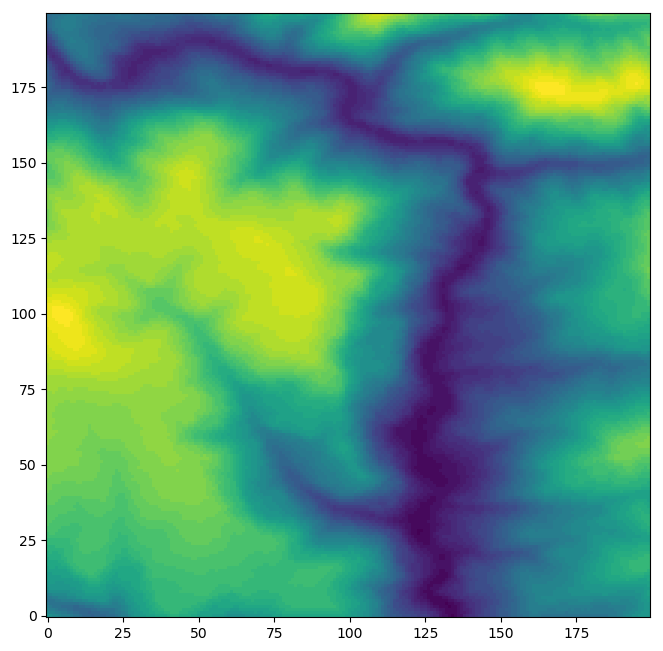

In [3]:
%matplotlib inline
#%matplotlib notebook
from meshmaker.plt import *

png = './datasets/srtm1/pngs/N45W116.png'
img = Config.load_img(png)

f, ax = plot()
ax.imshow(img, origin='lower')

In [ ]:
from meshmaker.obj import obj_world
from meshmaker.model import model

config = Config(png)
prefix = './disposable/'
mesh = trimesh()
models = (model(), )
#models[0].add(config.terrain_mesh(6, mesh), 'default')
models[0].add(config.skybox_mesh(bounds, mesh), 'default')
models[0].add(config.road_mesh(pg, mesh), 'default')
models[0].add(config.buildings_mesh(pg, fps, mesh), 'default')
textures = {'default': './resources/textures/orangeboxtex.png'}
obj_world(prefix, models, textures)

[[ 67  67  66 ... 197 198 198]
 [ 66  65  65 ... 198 198 199]
 [ 65  64  64 ... 198 199 199]
 ...
 [224 224 224 ... 200 199 198]
 [224 224 224 ... 200 199 198]
 [223 224 224 ... 199 198 198]]


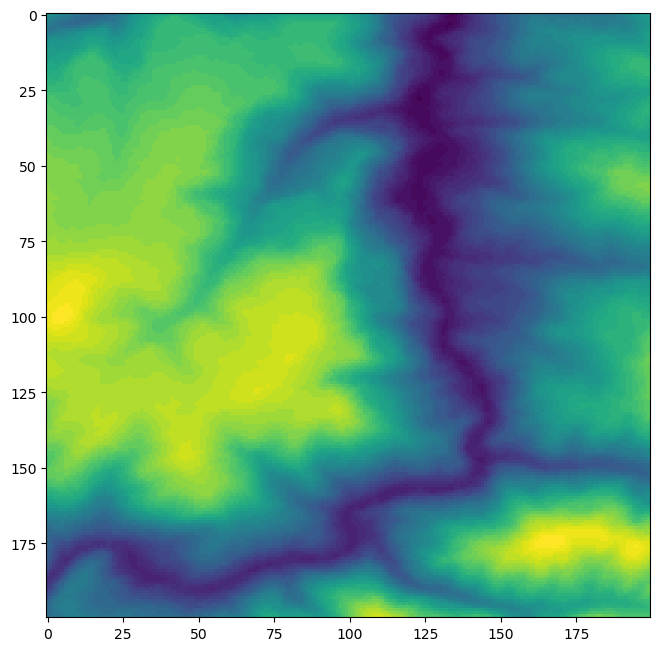

In [4]:
import numpy as np

class Capacitance:
    """ Population Density:
    Highways connect centers of population. To find the next population center, every highway road-end shoots
    a number of rays radially within a preset radius. Along this ray, samples of the population density are
    taken from the population density map. The population at every sample point on the ray is weighted with
    the inverse distance to the roadend and summed up. The direction with the largest sum is chosen for 
    continuing the growth.
    """

    def __init__(self):
        #self.img = normalize(perlin(200, 1, 1, 1))
        
        png = './datasets/srtm1/pngs/N45W116.png'
        self.img = normalize(Config.load_img(png))
        
        #self.img = normalize(capacity)
        #self.img = capacity
        
    def __getitem__(self, u):        
        x = min(self.img.shape[1] - 1, int(u.x))
        y = min(self.img.shape[0] - 1, int(u.y))
        return x, y
        
    def point(self, u):
        x, y = self[u]
        return self.img[y, x]

    def edge(self, u, v):
        #return self.point(u.lerp(v, 0.5))
        return self.point(u) + self.point(v)

    def point_highway(self, u, v, a):
        raise
        
    def sink(self, u, d=1, sig=10):
        x_0, y_0 = self[u]
        x = np.arange(self.img.shape[0])
        y = np.arange(self.img.shape[1])
        x, y = np.meshgrid(x, y)
        self.img -= d * np.exp(-((x - x_0) ** 2 + (y - y_0) ** 2) / sig)
        self.img = np.clip(self.img, 0, 1)

    def grad(self, u):
        x, y = self[u]
        dx, dy = np.gradient(self.img)
        return vec3(dx[y, x], dy[y, x], 0)

f, ax = plot()
ax.imshow(Capacitance().img)

In [5]:
class RoadSegment:

    Z = vec3.Z()
    
    def __init__(self, o, d, l, a, layer, parent, max_turning_rate=0):
        self.o, self.d, self.l, self.a = o, d, l, a
        self.layer = layer
        self.parent = parent
        self.max_turning_rate = max_turning_rate

    def growable(self, population_fd):
        return not (self.terminal or self.tip is None or population_fd.point(self.tip) < 0.03)
        
    @classmethod
    def grow(cls, parent, population_fd, street_fd, first_turn_rate, second_turn_rate):
        queue = []
        if parent.growable(population_fd):
            if parent.layer == 0:
                fd = population_fd.grad(parent.tip)
                turn_rate = first_turn_rate
            else:
                fd = street_fd(parent.tip)
                turn_rate = second_turn_rate
            l, a = parent.l, parent.a
            fwd = fd.nrm().rot(quat.av(parent.a, cls.Z))
            queue.append(cls(parent.tip, fwd, l, a, parent.layer, parent, turn_rate))
            #if parent.layer % 2 == 0:
            rgt = fd.nrm().rot(quat.av(parent.a + PI / 2, cls.Z))
            queue.append(cls(parent.tip, rgt, l, a + PI / 2, parent.layer + 1, parent, second_turn_rate))
            lft = fd.nrm().rot(quat.av(parent.a + 3 * PI / 2, cls.Z))
            queue.append(cls(parent.tip, lft, l, a + 3 * PI / 2, parent.layer + 1, parent, second_turn_rate))
        return queue
    
    def constrain_turning_rate(self):
        if self.parent is not None:            
            self_minor = bool((self.a / (PI / 2)) % 2)            
            parent_minor = bool((self.parent.a / (PI / 2)) % 2)
            oriented = self_minor == parent_minor
            alpha = self.parent.d.ang(self.d)
            if oriented:
                if alpha > self.max_turning_rate:
                    z = np.sign(self.parent.d.crs(self.d).z)
                    if not z == 0:
                        self.d.rot(quat.av(alpha - self.max_turning_rate, vec3(0, 0, -z)))
            else:
                z = np.sign(self.parent.d.crs(self.d).z)
                z = 1 if z == 0 else z
                self.d = self.parent.d.cp()
                self.d.rot(quat.av(PI / 2, vec3(0, 0, -z)))
        assert not np.isnan(self.d.x)        
    
    def constrain_to_boundary(self, bounds, tip):
        # glue to boundary intersections
        ebnd, ibnds = bounds
        ips = []
        for u, v in slide(ebnd, 2):
            ip = sintsxyp(u, v, self.o, tip, 1, 1, 1, 1)
            if isinstance(ip, vec3):
                ips.append(ip)
            elif ip is not None:
                for i in ip:
                    ips.append(i)
        ips = sorted(filter(None, ips), key=lambda ip: self.o.dxy(ip))
        tip = ips[0].cp() if ips else tip
        return tip
    
    def constrain(self, bounds, segments):
        """enforce local contraints based on existing segments and boundaries"""
        ## TODO: support ibnds; support turning at ebnd/ibnds
        
        self.constrain_turning_rate()
        
        tip = self.o + self.d * self.l
        eps = self.l / 1.5
        self.terminal = False

        tip = self.constrain_to_boundary(bounds, tip)

        # glue to sufficiently nearby intersections
        ips = [sintsxyp(s.o, s.tip, self.o, tip + self.d * eps, 0, 0, 0, 1) for s in segments]
        ips = sorted(filter(None, ips), key=lambda ip: self.o.dxy(ip))
        if ips:
            # if ip is not at u or v - split uv; flag for termination of growth
            tip = ips[0].cp()
            self.terminal = True
        
        # glue to sufficiently nearby crossings
        points = [s.o for s in segments] + [s.tip for s in segments]
        points = sorted(points, key=lambda p: p.dxy(tip))
        #points = sorted(points, key=lambda p: p.dexy(self.o.lerp(tip, 0.5), tip))
        if points and points[0].dxy(tip) < eps:
        #if points and points[0].dexy(self.o.lerp(tip, 0.5), tip) < eps:
            tip = points[0].cp()
            self.terminal = True
        else:
            crossing_tip = None
            
        self.tip = tip
        
        self.verify(segments, eps)
        
    def verify(self, segments, eps):
        if self.tip.dxy(self.o) < self.l / 100:
            self.tip = None
            return
        for segment in segments:
            if segment.o.isnear(self.o, eps):
                alpha = (segment.tip - segment.o).ang(self.tip - self.o)
            elif segment.o.isnear(self.tip, eps):
                alpha = (segment.tip - segment.o).ang(self.o - self.tip)
            elif segment.tip.isnear(self.o, eps):
                alpha = (segment.o - segment.tip).ang(self.tip - self.o)
            elif segment.tip.isnear(self.o, eps):
                alpha = (segment.o - segment.tip).ang(self.o - self.tip)
            else:
                alpha = None
            if alpha is not None and alpha < PI / 4:
                self.tip = None
                return
    
    def priority(self, population_fd):
        """compute priority for placing this segment (before applying local constraints)"""
        score = population_fd.edge(self.o, self.o + self.d * self.l)
        if self.layer == 0:
            score += 5
        return score

In [6]:
class RoadNetwork:
    
    def __init__(self, dl, first_turn_rate, second_turn_rate):
        self.dl = dl
        self.first_turn_rate = first_turn_rate
        self.second_turn_rate = second_turn_rate
        
    def init(self, bounds, root):
        population_fd = Capacitance()
        fd = population_fd.grad(root).nrm()
        if fd.mag() == 0:
            fd = vec3.X()
        queue = [
            RoadSegment(root, fd.cp()     , self.dl, 0, 0, None),
            RoadSegment(root, fd.cp().fp(), self.dl, 0, 0, None),
        ]
        street_fd = vec3_field.grid(vec3.O(), fd.cp(), 0.0, 0.001)
        return queue, population_fd, street_fd

    def grow(self, bounds, root, max_segments):
        queue, population_fd, street_fd = self.init(bounds, root)
        priority = lambda s: s.priority(population_fd)
        segments = []
        pg = planargraph()
        with tqdm(total=max_segments) as pbar:
            while queue and len(segments) < max_segments:
                segment = queue.pop(0)
                segment.constrain(bounds, segments)
                if segment.tip is not None:
                    i, j = pg.av(segment.o, 0.1), pg.av(segment.tip, 0.1)
                    if len(pg.rings[i]) < 4 and len(pg.rings[j]) < 4:
                        pg.ne(i, j, segment=segment)
                        segments.append(segment)
                        sink_value = 0.02 if segment.layer == 0 else 0.01
                        #population_fd.sink(segment.o  , d=sink_value, sig=100)
                        #population_fd.sink(segment.tip, d=sink_value, sig=20)
                        population_fd.sink(segment.o.lerp(segment.tip, 0.5), d=sink_value, sig=self.dl * 20)
                        population_fd.img = normalize(population_fd.img)
                        queue.extend(
                            RoadSegment.grow(segment, population_fd, street_fd,
                                             self.first_turn_rate, self.second_turn_rate))
                        queue.sort(key=priority, reverse=True)
                        pbar.update(1)
        return segments, queue, population_fd, pg

[[ 67  67  66 ... 197 198 198]
 [ 66  65  65 ... 198 198 199]
 [ 65  64  64 ... 198 199 199]
 ...
 [224 224 224 ... 200 199 198]
 [224 224 224 ... 200 199 198]
 [223 224 224 ... 199 198 198]]


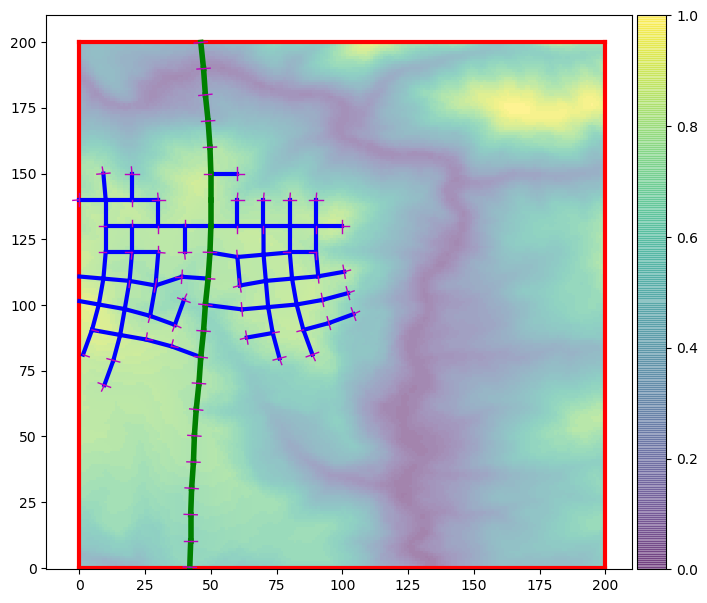

In [7]:
def grow_roads():
    dl = 10

    first_turn_rate = 2 * (PI / 180)
    #second_turn_rate = 0 * (PI / 180)
    
    #first_turn_rate = 20 * (PI / 180)
    second_turn_rate = 5 * (PI / 180)
    
    #first_turn_rate = 30 * (PI / 180)
    #second_turn_rate = 15 * (PI / 180)

    #bounds = (vec3(110, 90, 0).ring(90, 5), ())        
    
    #bounds = (vec3(300, 300, 0).ring(300, 4, False), ())        
    #root = vec3(400, 400, 0)
    
    bounds = (vec3(100, 100, 0).ring(100, 4, False), ())        
    root = vec3(50, 140, 0)
    
    max_segments = 100
    
    nx = RoadNetwork(dl, first_turn_rate, second_turn_rate)
    segments, queue, population_fd, pg = nx.grow(bounds, root, max_segments)
    
    #pg = nx.pg(segments)
    
    f, ax = plot()
    
    im = ax.imshow(population_fd.img, origin='lower', alpha=0.5)
    
    plot_loop(ax, bounds[0], col='r', lw=3)
    for seg in sorted(segments, key=lambda seg: seg.layer, reverse=True):
        col = 'g' if seg.layer == 0 else 'b'
        #col = 'g' if seg.a % PI / 2 == 0 else 'b'
        lw = 4 if seg.layer == 0 else 3
        plot_edge(ax, seg.o, seg.tip, col=col, lw=lw)    
    for seg in sorted(queue, key=lambda seg: seg.layer, reverse=True):
        col = 'r' if seg.layer == 0 else 'm'
        #col = 'g' if seg.a % PI / 2 == 0 else 'b'
        lw = 2 if seg.layer == 0 else 1
        seg.constrain_turning_rate()
        plot_edge(ax, seg.o, seg.o + seg.d * (seg.l / 4), col=col, lw=lw)
    
    #plot_pg(ax, pg, col='k', lw=2, mk='*', annotate=False)
    '''
    '''
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im, cax=cax)
    
    return pg, bounds

pg, bounds = grow_roads()

missing edge! 10 11 [(18, 10, 8), (18, 8, 11)]
missing edge! 11 12 [(15, 11, 8), (15, 8, 12)]
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
parcel = [vec3(47.8507, 109.1051, 0.0000), vec3(39.1036, 109.7168, 0.0000), vec3(29.8193, 106.6668, 0.0000), vec3(28.0298, 96.5180, 0.0000), vec3(35.6986, 93.7268, 0.0000), vec3(38.7767, 102.1840, 0.0000), vec3(40.6561, 101.5000, 0.0000), vec3(36.8939, 91.1634, 0.0000), vec3(26.5986, 94.9116, 0.0000), vec3(18.0353, 97.2051, 0.0000), vec3(16.6620, 89.4166, 0.0000), vec3(25.5681, 87.8452, 0.0000), vec3(35.3175, 85.2326, 0.0000), vec3(45.3052, 81.5477, 0.0000), vec3(46.2144, 90.1967, 0.0000), vec3(46.9120, 100.1724, 0.0000)]


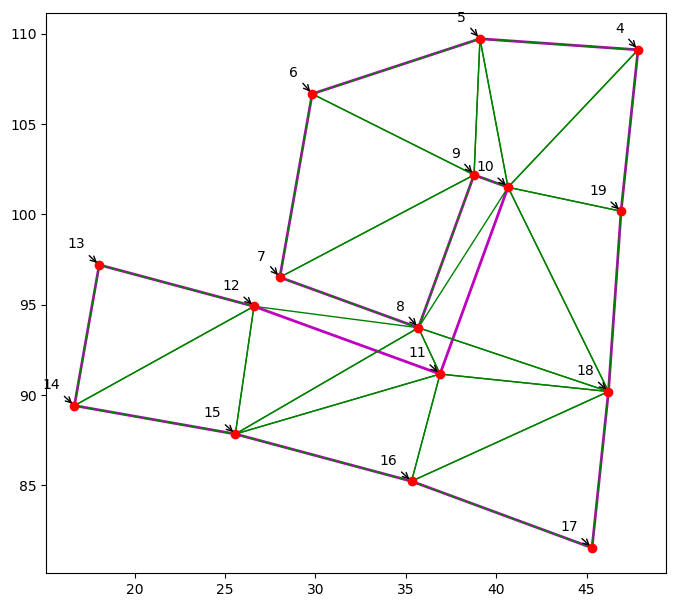

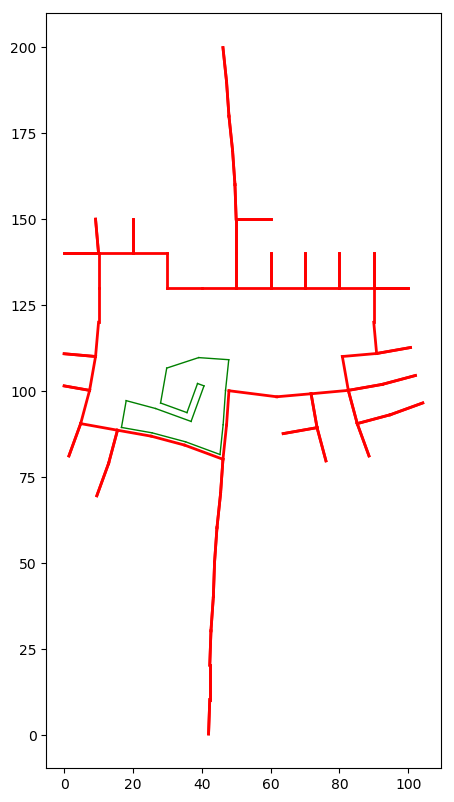

In [10]:
from meshmaker.delaunay import triangulation

def get_parcels(eb, ibs=()):

    eb = loop_offset(eb, 1)
    
    e, h, r = 0.00001, None, 1000
    t = triangulation((eb, ibs), e, h, r)
    
    #spine = medial_axis(t)

    # cast rays from spine to t.ghosts
    
    #for u, v, _ in filter(None, t.ghosts):
    #    spine.ae(t.points[u], t.points[v])

    #strips = [[spine.vertices[x] for x in l] for l in spine.loops()]

    f, ax = plot()
    t.plot(ax=ax)
    #plot_loop(ax, eb, lw=2, col='r', mk=None)
    #plot_pg(ax, spine, lw=3, col='k', mk=None)
    ax.set_aspect(1)

    #return strips
    return [eb]

def footprints(bounds, rg):
    eb, ibs = rg.polygon()
    
    parcels = []
    for ib in ibs[1:2]:
        parcels.extend(get_parcels(ib))
    
    f, ax = plot(figsize=(10, 10))
    
    plot_loop(ax, eb, lw=2, col='r')
    #for ib in ibs[1:]:
    #    plot_loop(ax, loop_offset(ib, 2), lw=1, col='b')
    for parcel in parcels:
        print('parcel =', parcel)
        plot_loop(ax, parcel, lw=1, col='g')

    ax.set_aspect(1)
    fps = []
    return fps
    
fps = footprints(bounds, pg)

In [9]:
from meshmaker.mesh import planargraph
from meshmaker.delaunay import triangulation
from meshmaker.vec3 import vec3
from meshmaker.geometry import sintsxyp, circumcircle
from meshmaker.plt import *
%matplotlib inline


def medial_axis(tri):


    def obtuse_interior_steiners(tri, u, v, w):
        tritype = tri.triangletype(u, v, w)
        if not tritype == 0:
            return
        p, q, r = tri.points[u], tri.points[v], tri.points[w]
        cc, cr = circumcircle(p, q, r)
        if cc.inbxy([p, q, r], True):
            return
        pq, qr, rp = q.d(p), r.d(q), p.d(r)
        longest = max(pq, qr, rp)
        o = w if longest == pq else (v if longest == rp else u)
        op = tri.points[o]
        for x, y, z in filter(None, tri.triangles):
            a, b, c = tri.points[x], tri.points[y], tri.points[z]
            v0 = None
            if tri.adjacent(y, x) == -2 and sintsxyp(op, cc, a, b, 0, 0, 0, 1):
                v0 = x if x in (u, v, w) else y
                n, m = a, b
            elif tri.adjacent(z, y) == -2 and sintsxyp(op, cc, b, c, 0, 0, 0, 1):
                v0 = y if y in (u, v, w) else z
                n, m = c, b
            elif tri.adjacent(x, z) == -2 and sintsxyp(op, cc, c, a, 0, 0, 0, 1):
                v0 = z if z in (u, v, w) else x
                n, m = a, c
            if v0 is not None:
                p0 = [_ for _ in (u, v, w) if not (_ == v0 or _ == o)][0]
                p0 = op.lerp(tri.points[p0], 0.5)
                steiner = sintsxyp(p0, cc, n, m, 0, 0, 0, 1)
                tri.insertpoint(steiner, tri.epsilon)            
                if longest == pq:
                    tri.flipedge(u, v)
                elif longest == qr:
                    tri.flipedge(v, w)
                elif longest == rp:
                    tri.flipedge(w, u)
                break # "usually" only one triangle needs to be modified, allegedly..


    def convex_vertex_steiners(tri, u, corners):
        adjs = []
        for x, y, _ in filter(None, tri.ghosts):
            if u == x and not y in adjs:
                adjs.insert(0, y)
            elif u == y and not x in adjs:
                adjs.append(x)
        if adjs:
            
            if not len(adjs) == 2:
                print(adjs, u)
                f, ax = plot()
                plot_loop(ax, tri.polygon[0])
                plot_point(ax, tri.points[u], mk='*', col='r')
                for o in adjs:
                    plot_edge(ax, tri.points[u], tri.points[o], col='r', lw=2)
                #ax.set_xlim(50-0.01, 50+0.01)
                #ax.set_ylim(130-0.01, 130+0.01)
            
            x, y = adjs
            p, q, r = tri.points[u], tri.points[x], tri.points[y]
            if p.leftof(q, r) < 0:
                d = min([p.dxy(tri.points[o]) for o in corners if not u == o]) / 2
                steiner = p + (r - p).nrm() * d
                if tri._fp(steiner, tri.epsilon) < 0:
                    tri.insertpoint(steiner, tri.epsilon)
                steiner = p + (q - p).nrm() * d
                if tri._fp(steiner, tri.epsilon) < 0:
                    tri.insertpoint(steiner, tri.epsilon)
                key = lambda e: tri.trianglelookup[e] is not None and u in e
                for a, b in filter(key, tuple(tri.trianglelookup.keys())):
                    if not tri.adjacent(b, a) < 0:
                        tri.flipedge(a, b)


    def process_tri(tri, u, v, w, stack=None):
        stack = [] if stack is None else stack[:]
        i = tri.trianglelookup[(u, v)]
        if i not in seen:
            seen.add(i)

            x, y, z = tri.adjacent(v, u), tri.adjacent(w, v), tri.adjacent(u, w)
            l = (x, y, z).count(-2)

            p, q, r = tri.points[u], tri.points[v], tri.points[w]

            if l == 0:
                cc, cr = circumcircle(p, q, r)
                if cc.inbxy([p, q, r], True):
                    stack.append((pg.av(cc), l))
                    if len(stack) > 1:
                        pg.ne(stack[-1][0], stack[-2][0])
                else:
                    stack.append((stack[-1][0], l))
                    pq, qr, rp = q.d(p), r.d(q), p.d(r)
                    longest = max(pq, qr, rp)
                    o = w if longest == pq else (v if longest == rp else u)
                    o = tri.points[o]
                    for a, b, c in filter(None, tri.triangles):
                        ll = tri.triangletype(a, b, c)
                        if ll == 1:
                            d, e, f = tri.points[a], tri.points[b], tri.points[c]
                            if sintsxyp(o, cc, d, e, 0, 0, 0, 1):
                                enabled[tri.trianglelookup[(a, b)]] = False
                            elif sintsxyp(o, cc, e, f, 0, 0, 0, 1):
                                enabled[tri.trianglelookup[(a, b)]] = False
                            elif sintsxyp(o, cc, f, d, 0, 0, 0, 1):
                                enabled[tri.trianglelookup[(a, b)]] = False

            elif l == 1:
                if enabled[i]:  
                    if x < 0:
                        j, k = tri.trianglelookup[(w, v)], tri.trianglelookup[(u, w)]
                        if j in seen:
                            o = pg.av(p.lerp(r, 0.5))
                        elif k in seen:
                            o = pg.av(q.lerp(r, 0.5))
                    elif y < 0:
                        j, k = tri.trianglelookup[(v, u)], tri.trianglelookup[(u, w)]
                        if j in seen:
                            o = pg.av(r.lerp(p, 0.5))
                        elif k in seen:
                            o = pg.av(q.lerp(p, 0.5))
                    elif z < 0:
                        j, k = tri.trianglelookup[(w, v)], tri.trianglelookup[(v, u)]
                        if j in seen:
                            o = pg.av(p.lerp(q, 0.5))
                        elif k in seen:
                            o = pg.av(r.lerp(q, 0.5))
                    else:
                        raise
                    pg.ne(stack[-1][0], o)
                    stack.append((o, l))

            elif l == 2:
                o, ll = stack.pop(-1)
                while ll == 1:
                    pg.rv(o)
                    o, ll = stack.pop(-1)
                oo = w if x >= 0 else (u if y >= 0 else v)
                oo = pg.av(tri.points[oo].cp())
                pg.ne(o, oo)

            plot_loop(ax, [p, q, r], col='b', lw=0.2, ls='-.')

            mod = False
            if x >= 0:
                mod = process_tri(tri, x, v, u, stack) or mod
            if y >= 0:
                mod = process_tri(tri, y, w, v, stack) or mod
            if z >= 0:
                mod = process_tri(tri, z, u, w, stack) or mod
            if not mod and not l == 2:
                print('connect stray!')
            return True
        return False
            

    
    for u, v, w in filter(None, tri.triangles):
        obtuse_interior_steiners(tri, u, v, w)
    corners = set()
    for x, y, _ in filter(None, tri.ghosts):
        corners.add(x)
        corners.add(y)
    for u in range(len(tri.points)):
        if tri.onboundary(u, tri.epsilon):
            convex_vertex_steiners(tri, u, corners)
    tri.delaunay()
    enabled = {i: True for i, t in enumerate(tri.triangles) if t is not None}    
    seen = set()
    pg = planargraph()
    for u, v, w in filter(None, tri.triangles):
        ll = tri.triangletype(u, v, w)
        if ll == 0:
            #process_tri(tri, u, v, w)
            break


            
    print(len(seen), seen)
    plot_pg(ax, pg, lw=2, mk=None, annotate=False)


    return pg

In [11]:
from meshmaker.delaunay import triangulation

def lottify(eb, ibs=()):

    e, h, r = 0.00001, None, 1000
    t = triangulation((eb, ibs), e, h, r)
    
    spine = medial_axis(t)

    #for u, v, w in filter(None, t.triangles):
    #    obtuse_interior_steiners(t, u, v, w)

    #corners = set()
    #for x, y, _ in filter(None, t.ghosts):
    #    corners.add(x)
    #    corners.add(y)
        
    #for u in range(len(t.points)):
    #    if t.onboundary(u, t.epsilon):
    #        convex_vertex_steiners(t, u, corners)
            
    #t.delaunay()

    f, ax = plot()
    plot_loop(ax, eb, lw=2, col='r', mk=None)
    t.plot(ax=ax)
    plot_pg(ax, spine, lw=3, col='k', mk=None)
    ax.set_aspect(1)
    
    return t
    
tri = lottify(fps[0])

NameError: name 'fps' is not defined

connect stray!
24 {55, 56, 57, 62, 63, 67, 68, 70, 71, 72, 75, 76, 78, 79, 82, 84, 86, 88, 91, 92, 94, 95, 96, 97}


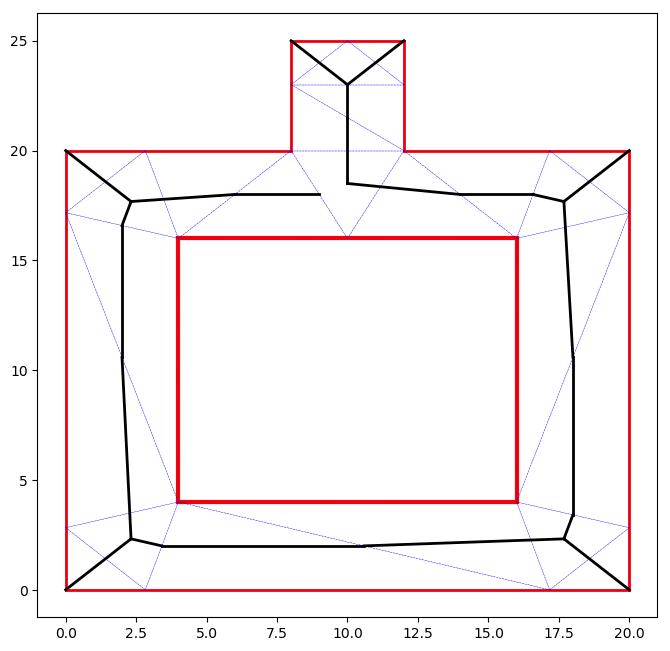

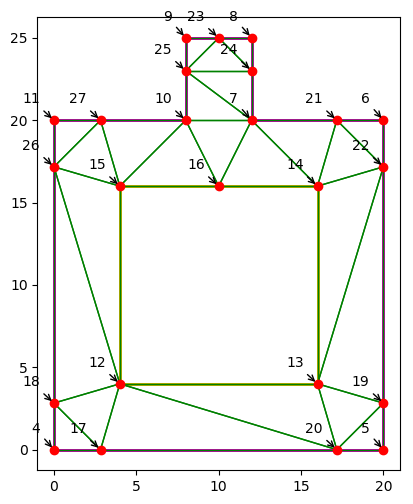

In [17]:
from meshmaker.mesh import planargraph
from meshmaker.delaunay import triangulation
from meshmaker.vec3 import vec3
from meshmaker.geometry import sintsxyp, circumcircle
from meshmaker.plt import *
%matplotlib inline


def test_medial_axis():
    
    eb = [
        vec3(0, 0, 0),
        vec3(20, 0, 0),
        vec3(20, 20, 0),
        vec3(12, 20, 0),
        vec3(12, 25, 0),
        vec3(8, 25, 0),
        vec3(8, 20, 0),
        vec3(0, 20, 0),
    ]
    ibs = [[
        vec3(4, 4, 0),
        vec3(16, 4, 0),
        vec3(16, 16, 0),
        vec3(4, 16, 0),
    ]]
    
    '''
    eb = [
        vec3(0, 0, 0),
        vec3(20, 0, 0),
        vec3(20, 10, 0),
        vec3(0, 10, 0),
    ]
    ibs = []
    '''
    
    e, h, r = 0.00001, None, 1000
    t = triangulation((eb, ibs), e, h, r)

    '''
    for u, v, w in filter(None, t.triangles):
        obtuse_interior_steiners(t, u, v, w)

    corners = set()
    for x, y, _ in filter(None, t.ghosts):
        corners.add(x)
        corners.add(y)
        
    for u in range(len(t.points)):
        if t.onboundary(u, t.epsilon):
            convex_vertex_steiners(t, u, corners)
            
    t.delaunay()
    '''

    spine = medial_axis(t)
        
    #t = triangulation((eb, ()), e, h, r)

    #steiners(t)
    
    f, ax = plot(figsize=(6, 6))
    plot_loop(ax, eb, col='r', mk=None, lw=2)
    for ib in ibs:
        plot_loop(ax, ib, col='r', mk=None, lw=2)
    t.plot(ax=ax)
    ax.set_aspect(1)

test_medial_axis()

missing edge! vec3(40.6561, 101.5000, 0.0000) 10 vec3(36.8939, 91.1634, 0.0000) 11 [(18, 10, 8), (18, 8, 11)]
missing edge! vec3(36.8939, 91.1634, 0.0000) 11 vec3(26.5986, 94.9116, 0.0000) 12 [(15, 11, 8), (15, 8, 12)]
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost
missingghost


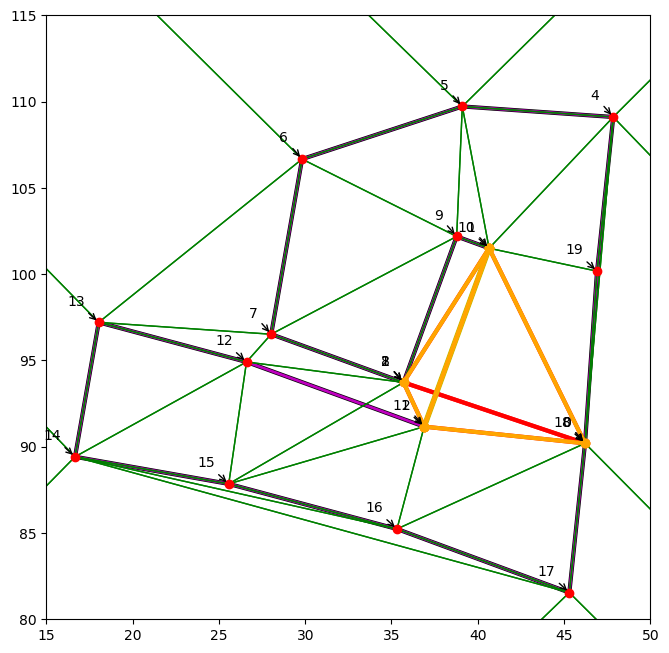

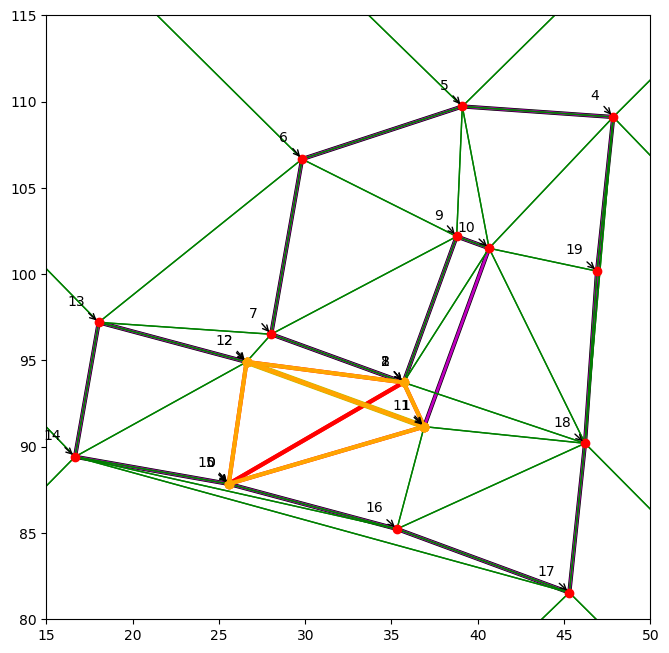

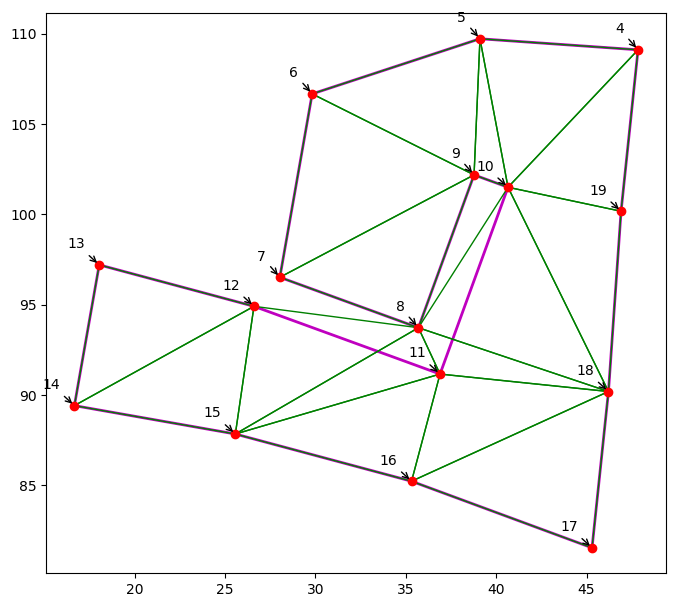

In [6]:
from meshmaker.plt import *
from meshmaker.delaunay import triangulation
from meshmaker.vec3 import vec3
from meshmaker.mesh import planargraph
from meshmaker.geometry import sintsxyp


def fill(self):

    
def constrain(self):
    """force all input domain edges into the triangulation"""

    for p, q in self.edges:
        u = self._fp(p, e=self.epsilon)
        v = self._fp(q, e=self.epsilon)
        if self.trianglelookup.get((u, v)) is None:
            bad = []
            pg = planargraph()
            for x, y, z in filter(None, self.triangles):
                a, b, c = self.points[x], self.points[y], self.points[z]
                ip1 = sintsxyp(p, q, a, b, 0, 0, 0, 1)
                ip2 = sintsxyp(p, q, b, c, 0, 0, 0, 1)
                ip3 = sintsxyp(p, q, c, a, 0, 0, 0, 1)
                if any((ip1, ip2, ip3)):
                    pg.ne(pg.nv(p), pg.nv(q))
                    bad.append((x, y, z))
                    if ip1 is None:
                        pg.ne(pg.nv(a), pg.nv(b))
                    if ip2 is None:
                        pg.ne(pg.nv(b), pg.nv(c))
                    if ip3 is None:
                        pg.ne(pg.nv(c), pg.nv(a))
                

            print('missing edge!', p, u, q, v, bad)
            
            f, ax = plot()
            plot_loop(ax, parcel, mk=None)
            self.plot(ax=ax)
            for t in bad:
                plot_loop(ax, [self.points[i] for i in t], col='r', lw=3, mk='*')
            plot_edge(ax, p, q, lw=4, col='y')
            plot_pg(ax, pg, col='orange', lw=3)
            ax.set_aspect(1)
            ax.set_xlim(15, 50)
            ax.set_ylim(80, 115)
    
                
parcel = [vec3(47.8507, 109.1051, 0.0000), vec3(39.1036, 109.7168, 0.0000), vec3(29.8193, 106.6668, 0.0000), vec3(28.0298, 96.5180, 0.0000), vec3(35.6986, 93.7268, 0.0000), vec3(38.7767, 102.1840, 0.0000), vec3(40.6561, 101.5000, 0.0000), vec3(36.8939, 91.1634, 0.0000), vec3(26.5986, 94.9116, 0.0000), vec3(18.0353, 97.2051, 0.0000), vec3(16.6620, 89.4166, 0.0000), vec3(25.5681, 87.8452, 0.0000), vec3(35.3175, 85.2326, 0.0000), vec3(45.3052, 81.5477, 0.0000), vec3(46.2144, 90.1967, 0.0000), vec3(46.9120, 100.1724, 0.0000)]

e, h, r = 0.00001, None, 1000
t = triangulation((parcel, ()), e, h, r, constrain)

f, ax = plot()
#plot_loop(ax, parcel, mk=None)
t.plot(ax=ax)
ax.set_aspect(1)


1 1


AttributeError: 'NoneType' object has no attribute 'x'

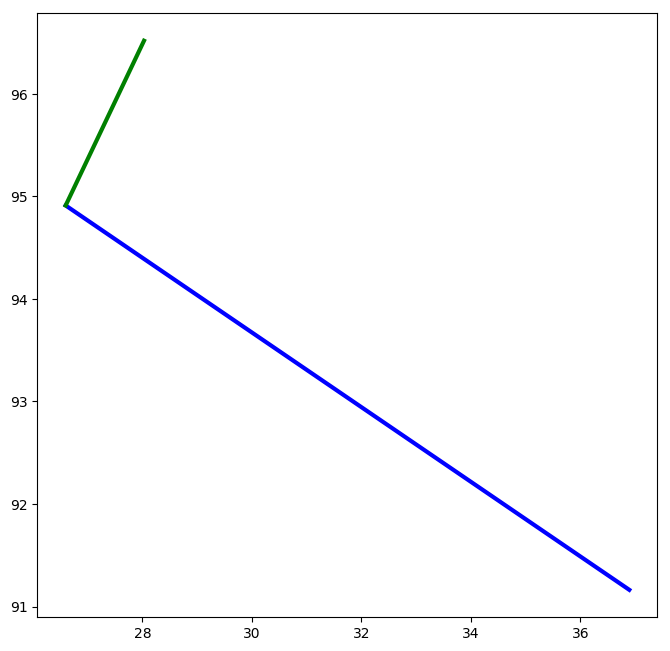

In [1]:
%matplotlib inline
from meshmaker.plt import *
from meshmaker.vec3 import vec3
from meshmaker.geometry import sintsxyp

p, q, a, b = (vec3(36.8939, 91.1634, 0.0000), vec3(26.5986, 94.9116, 0.0000), vec3(28.0298, 96.5180, 0.0000), vec3(26.5986, 94.9116, 0.0000))
#vec3(36.8939, 91.1634, 0.0000) vec3(26.5986, 94.9116, 0.0000) vec3(18.0353, 97.2051, 0.0000) vec3(26.5986, 94.9116, 0.0000)
#vec3(36.8939, 91.1634, 0.0000) vec3(26.5986, 94.9116, 0.0000) vec3(35.6986, 93.7268, 0.0000) vec3(25.5681, 87.8452, 0.0000)
#vec3(36.8939, 91.1634, 0.0000) vec3(26.5986, 94.9116, 0.0000) vec3(25.5681, 87.8452, 0.0000) vec3(35.6986, 93.7268, 0.0000)

f, ax= plot()

plot_edge(ax, p, q, col='b')
plot_edge(ax, a, b, col='g')

ip = sintsxyp(p, q, a, b, 0, 0, 0, 1)

plot_point(ax, ip, mk='*', col='r')

In [10]:
ip.isnear(p), ip.isnear(q), ip.isnear(a), ip.isnear(b)

(False, True, False, True)